In [1]:
#Import libraries
import os
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

#tensorflow 2.4.0
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import layers, models

#https://www.tensorflow.org/tutorials/images/classification?hl=ko

In [2]:
#Use GPU
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 4901538232121851740,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 4922553139
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 5948652718349104858
 physical_device_desc: "device: 0, name: GeForce GTX 1060 6GB, pci bus id: 0000:01:00.0, compute capability: 6.1"]

In [3]:
#Initailize setting
#data_dir = pathlib.Path('../gender-class-tf-data')
data_dir = pathlib.Path(r'C:\Users\yang\Desktop\gender-data')
save_path = os.getcwd()
class_names = np.array([item.name for item in data_dir.glob('*')])
print(class_names)

['Female' 'Male']


In [4]:
#Load dataset
#data source: https://www.kaggle.com/jessicali9530/celeba-dataset
batch_size = 128
img_height = 100
img_width = 100

train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir,
                                                               color_mode="grayscale",
                                                               validation_split=0.3,
                                                               subset="training",
                                                               seed=112,
                                                               image_size=(img_height, img_width),
                                                               batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir,
                                                             color_mode="grayscale",
                                                             validation_split=0.3,
                                                             subset="validation",
                                                             seed=112,
                                                             image_size=(img_height, img_width),
                                                             batch_size=batch_size)

Found 30000 files belonging to 2 classes.
Using 21000 files for training.
Found 30000 files belonging to 2 classes.
Using 9000 files for validation.


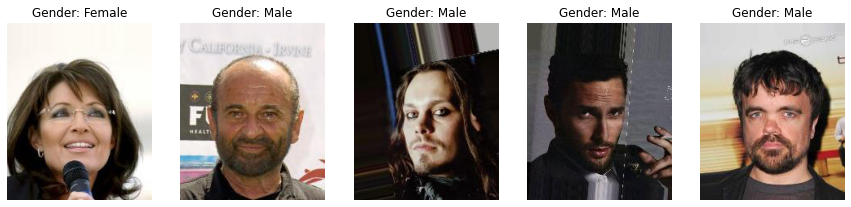

In [5]:
#print few random pictures
n = 5
fig, axes = plt.subplots(1, n, figsize=(15,15))

for i in range(n):
    random_gender = random.choice(class_names)
    random_image = random.choice(list(data_dir.glob(random_gender+'/*.jpg')))
    image = plt.imread(random_image)
    axes[i].imshow(image)
    axes[i].set_title("Gender: "+random_gender)
    axes[i].axis('off')

In [6]:
#Improve dataset performance
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [7]:
#Data Augmentation
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height, img_width, 1)),
    layers.experimental.preprocessing.RandomRotation(0.05),
    layers.experimental.preprocessing.RandomZoom(0.1),
])

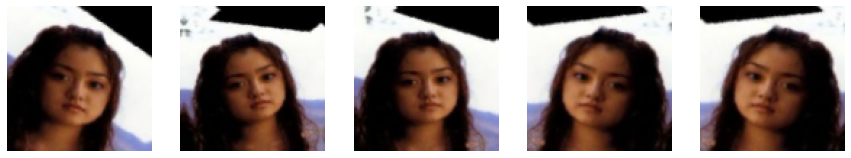

In [8]:
#print random picture's augmented version
plt.figure(figsize=(15, 15))

random_gender = random.choice(class_names)
random_image = random.choice(list(data_dir.glob(random_gender+'/*.jpg')))
img = tf.keras.preprocessing.image.load_img(random_image, target_size=(img_height, img_width))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)
for i in range(5):
    augmented_images = data_augmentation(img_array)
    ax = plt.subplot(1, 5, i+1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [9]:
#Make model
num_classes = 2

model = tf.keras.models.Sequential([
    data_augmentation,
    layers.experimental.preprocessing.Rescaling(1./255),
    layers.Conv2D(8, (7, 7), activation='relu'),
    layers.Conv2D(16, (5, 5), activation='relu'),
    tfa.layers.GroupNormalization(groups=4, axis=3),
    layers.AveragePooling2D(),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    tfa.layers.GroupNormalization(groups=4, axis=3),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    tfa.layers.GroupNormalization(groups=8, axis=3),
    layers.MaxPooling2D(),
    layers.Dropout(0.3),
    layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    tfa.layers.GroupNormalization(groups=8, axis=3),
    layers.MaxPooling2D(),
    layers.Dropout(0.3),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(num_classes, activation='softmax')
])

In [10]:
#Model compile and summary
model.compile(optimizer='adam',
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 100, 100, 1)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 100, 100, 1)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 94, 94, 8)         400       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 16)        3216      
_________________________________________________________________
group_normalization (GroupNo (None, 90, 90, 16)        32        
_________________________________________________________________
average_pooling2d (AveragePo (None, 45, 45, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 43, 43, 32)       

In [11]:
tf.saved_model.load(save_path)

<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject at 0x1a578616c40>

In [12]:
#Training
epochs = 100
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/100
165/165 [==============================] - 43s 156ms/step - loss: 0.9647 - accuracy: 0.5500 - val_loss: 0.6057 - val_accuracy: 0.6559
Epoch 2/100
165/165 [==============================] - 21s 126ms/step - loss: 0.5896 - accuracy: 0.6853 - val_loss: 0.4827 - val_accuracy: 0.7778
Epoch 3/100
165/165 [==============================] - 21s 126ms/step - loss: 0.4556 - accuracy: 0.7855 - val_loss: 0.2321 - val_accuracy: 0.9090
Epoch 4/100
165/165 [==============================] - 21s 126ms/step - loss: 0.2564 - accuracy: 0.8942 - val_loss: 0.1881 - val_accuracy: 0.9244
Epoch 5/100
165/165 [==============================] - 21s 127ms/step - loss: 0.2242 - accuracy: 0.9095 - val_loss: 0.1944 - val_accuracy: 0.9226
Epoch 6/100
165/165 [==============================] - 21s 127ms/step - loss: 0.2023 - accuracy: 0.9186 - val_loss: 0.1661 - val_accuracy: 0.9336
Epoch 7/100
165/165 [==============================] - 21s 127ms/step - loss: 0.1907 - accuracy: 0.9225 - val_loss: 0.1585 -

In [13]:
#Save model
tf.saved_model.save(model, save_path)

INFO:tensorflow:Assets written to: C:\Users\yang\Documents\GitHub\gender-classification-tensorflow\assets


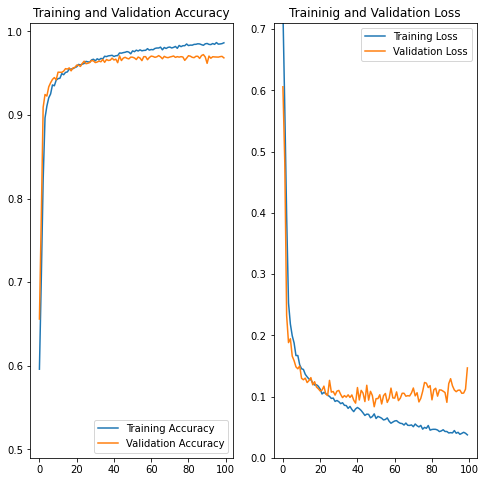

In [14]:
#Accuracy and loss graph
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.ylim(0.49, 1.01)
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.ylim(0, 0.71)
plt.legend(loc='upper right')
plt.title('Traininig and Validation Loss')
plt.show()

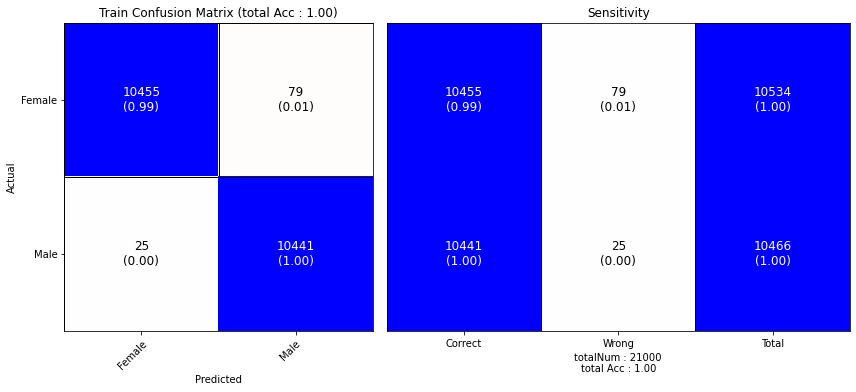

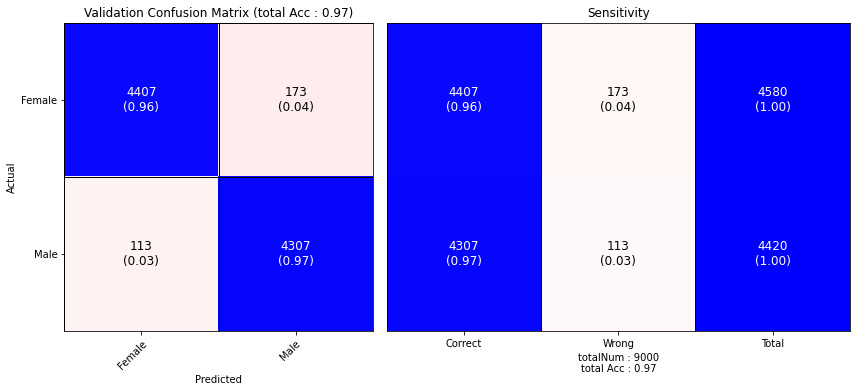

In [25]:
#Confusion matrix
import plotConfusionMatrix as pcm

predictions_t = np.array([])
labels_t = np.array([])
predictions_v = np.array([])
labels_v = np.array([])

for x, y in train_ds:
    predictions_t = np.concatenate([predictions_t, np.argmax(model.predict(x), axis=-1)])
    labels_t = np.concatenate([labels_t, y])
    
for x, y in val_ds:
    predictions_v = np.concatenate([predictions_v, np.argmax(model.predict(x), axis=-1)])
    labels_v = np.concatenate([labels_v, y])
    
pcm.plotConfusionMatrix(predictions_t, labels_t, class_names, 'Train ')
pcm.plotConfusionMatrix(predictions_v, labels_v, class_names, 'Validation ')